Analyze the loan datas from Lending Club

In this project, I will use  to estimate whether a borrower will fully pay his/her loan based on the application infomation.
Download the data from the website

Packages used: pandas,

In [1]:
!pip install tensorflow_decision_forests

     |████████████████████████████████| 11.9 MB 5.9 MB/s eta 0:00:01


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, fbeta_score
from sklearn.preprocessing import MaxAbsScaler

Part A: Removing useless columns

First of all, import the data and remove duplicate.

In [5]:
loans_2007 = pd.read_csv('loans_2007.csv')
loans_2007.drop_duplicates()
loans_2007.info()
print(loans_2007.head())

/Users/zaiyingqi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          42538 non-null  object 
 1   member_id                   42535 non-null  float64
 2   loan_amnt                   42535 non-null  float64
 3   funded_amnt                 42535 non-null  float64
 4   funded_amnt_inv             42535 non-null  float64
 5   term                        42535 non-null  object 
 6   int_rate                    42535 non-null  object 
 7   installment                 42535 non-null  float64
 8   grade                       42535 non-null  object 
 9   sub_grade                   42535 non-null  object 
 10  emp_title                   39909 non-null  object 
 11  emp_length                  41423 non-null  object 
 12  home_ownership              42535 non-null  object 
 13  annual_inc                  425

Now begin to reduce the columns of the data.

From the description, we can remove some features. They are listed below:

Identity-based data: 'id', 'member_id'. We should take out these data(morally and technically).

Same effect data: 'grade', 'sub_grade'. They are as same as the int_rate; zip_code. It is as same as the 'addrs_ate' as it only reveals 3 digits; 'title': it has a similar effect as 'purpose'.

Lender related: 'funded_amnt', 'funded_amnt_inv', 'issue_d', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d'. 
They are features related to the current lander, which we don't have when being a potential lander.

Other: 'last_credit_pull_d', 'earliest_cr_line'

In [6]:
loans_2007 = loans_2007.drop(["id", "member_id", "funded_amnt", "funded_amnt_inv", "grade", "sub_grade", "issue_d"], axis=1)
loans_2007 = loans_2007.drop(["zip_code", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp"], axis=1)
loans_2007 = loans_2007.drop(["total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt"], axis=1)
loans_2007 = loans_2007.drop(["last_credit_pull_d", "earliest_cr_line", 'title'], axis=1)

There are some special that are hard to replace na. For example, more than 30659 different title are filled in emp_title. Thus we have to remove it. Also, too many unique values make it useless here.

In [7]:
print(sum(loans_2007["emp_title"].isna()))
print(len(loans_2007['emp_title'].unique()))
loans_2007 = loans_2007.drop(['emp_title'], axis = 1)

2629
30659


Finally, if a column only contains one single value(except na), it contributes nothing to our model. 

In [8]:
cur_col_for_one = loans_2007.nunique()
print(cur_col_for_one)
remove_one = []
for idx, value in cur_col_for_one.items():
    if value == 1:
        remove_one.append(idx)
print(remove_one)
loans_2007 = loans_2007.drop(remove_one, axis=1)
# pymnt_plan, initial_list_status, collections_12_mths_ex_med, policy_code
# application_type, acc_now_delinq, chargeoff_within_12_mths, delinq_amnt

loan_amnt                       898
term                              2
int_rate                        394
installment                   16459
emp_length                       11
home_ownership                    5
annual_inc                     5597
verification_status               3
loan_status                       9
pymnt_plan                        2
purpose                          14
addr_state                       50
dti                            2894
delinq_2yrs                      12
inq_last_6mths                   28
open_acc                         44
pub_rec                           6
revol_bal                     22709
revol_util                     1119
total_acc                        83
initial_list_status               1
collections_12_mths_ex_med        1
policy_code                       1
application_type                  1
acc_now_delinq                    2
chargeoff_within_12_mths          1
delinq_amnt                       3
pub_rec_bankruptcies        

In [9]:
loans_2007.info()
print(loans_2007.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             42535 non-null  float64
 1   term                  42535 non-null  object 
 2   int_rate              42535 non-null  object 
 3   installment           42535 non-null  float64
 4   emp_length            41423 non-null  object 
 5   home_ownership        42535 non-null  object 
 6   annual_inc            42531 non-null  float64
 7   verification_status   42535 non-null  object 
 8   loan_status           42535 non-null  object 
 9   pymnt_plan            42535 non-null  object 
 10  purpose               42535 non-null  object 
 11  addr_state            42535 non-null  object 
 12  dti                   42535 non-null  float64
 13  delinq_2yrs           42506 non-null  float64
 14  inq_last_6mths        42506 non-null  float64
 15  open_acc           

Now, let's deal with the main output: 'loan_status'. Firstly, let's see how many cases it has.

In [10]:
print(loans_2007['loan_status'].value_counts())

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64


According to the definition, here we only care about 'Fully Paid' or 'Charged Off'. As a lander, we welcome the first case and try to avoid the second case. We will use the binary number to replace it.

In [11]:
loans_2007 = loans_2007[(loans_2007['loan_status'] == 'Fully Paid') | (loans_2007['loan_status'] == 'Charged Off')]

status_replace = {
    "loan_status" : {
        "Fully Paid": 1,
        "Charged Off": 0,
    }
}
loans_2007 = loans_2007.replace(status_replace)

After dropping many rows, there are more single-value columns. Thus we have to redo the drop process.

In [12]:
loans_2007.info()
print(loans_2007['loan_status'])
cur_col_for_one = loans_2007.nunique()
print(cur_col_for_one)
remove_one = []
for idx, value in cur_col_for_one.items():
    if value == 1:
        remove_one.append(idx)
print(remove_one)
loans_2007 = loans_2007.drop(remove_one, axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38770 entries, 0 to 39785
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38770 non-null  float64
 1   term                  38770 non-null  object 
 2   int_rate              38770 non-null  object 
 3   installment           38770 non-null  float64
 4   emp_length            37734 non-null  object 
 5   home_ownership        38770 non-null  object 
 6   annual_inc            38770 non-null  float64
 7   verification_status   38770 non-null  object 
 8   loan_status           38770 non-null  int64  
 9   pymnt_plan            38770 non-null  object 
 10  purpose               38770 non-null  object 
 11  addr_state            38770 non-null  object 
 12  dti                   38770 non-null  float64
 13  delinq_2yrs           38770 non-null  float64
 14  inq_last_6mths        38770 non-null  float64
 15  open_acc           

We have dropped all unwanted columns and reduced the rows based on the output, now it's time to clean the rest input data.

Part B: Preparing data

In [13]:
print(loans_2007.info())
print(loans_2007.nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38770 entries, 0 to 39785
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38770 non-null  float64
 1   term                  38770 non-null  object 
 2   int_rate              38770 non-null  object 
 3   installment           38770 non-null  float64
 4   emp_length            37734 non-null  object 
 5   home_ownership        38770 non-null  object 
 6   annual_inc            38770 non-null  float64
 7   verification_status   38770 non-null  object 
 8   loan_status           38770 non-null  int64  
 9   purpose               38770 non-null  object 
 10  addr_state            38770 non-null  object 
 11  dti                   38770 non-null  float64
 12  delinq_2yrs           38770 non-null  float64
 13  inq_last_6mths        38770 non-null  float64
 14  open_acc              38770 non-null  float64
 15  pub_rec            

First of all, solve the missing values.

In [14]:
null_counts = loans_2007.isnull().sum()
print(null_counts[null_counts>0])

emp_length              1036
revol_util                50
pub_rec_bankruptcies     697
dtype: int64


If the missing values is small compared to the dataset, just drop it. That is, title, revol_util, last_credit_pull_d.

In [15]:
loans_2007 = loans_2007.dropna(subset=['revol_util'])

Now let's deal with emp_length and pub_rec_bankruptcies.

In [16]:
for idx, value in null_counts[null_counts>0].items():
    print(loans_2007[idx].value_counts(normalize=True, dropna=False))

10+ years    0.220713
< 1 year     0.116606
2 years      0.111131
3 years      0.103874
4 years      0.086648
5 years      0.082774
1 year       0.082051
6 years      0.056250
7 years      0.044292
8 years      0.037242
9 years      0.031741
NaN          0.026679
Name: emp_length, dtype: float64
0%        0.024793
0.2%      0.001627
63%       0.001601
40.7%     0.001498
66.7%     0.001472
            ...   
0.16%     0.000026
38.77%    0.000026
21.59%    0.000026
58.77%    0.000026
21.72%    0.000026
Name: revol_util, Length: 1088, dtype: float64
0.0    0.939385
1.0    0.042485
NaN    0.018001
2.0    0.000129
Name: pub_rec_bankruptcies, dtype: float64


Typically, there are several ways to fill it. 

If we have enough side information, we could deduce the most possible answer. 

Or we could use mean or mode to replace it. Here, since the percentage of na in pub_rec_bankruptcies is small, we could replace na with the mode, namely 0.0. 

For emp_length, it's a hard issue, since adding it to any part will increase its portion significantly. Thus we drop the na of it.

In [17]:
loans_2007['pub_rec_bankruptcies'] = loans_2007['pub_rec_bankruptcies'].fillna(0.0)
loans_2007 = loans_2007.dropna()

Now we have solved the missing values. Let's transform the categorical columns into numbers.

In [18]:
loans_2007.info()
object_col = []
for col, dty in loans_2007.dtypes.to_dict().items():
    if dty == 'object':
        object_col.append(col)
print(object_col)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37687 entries, 0 to 39785
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             37687 non-null  float64
 1   term                  37687 non-null  object 
 2   int_rate              37687 non-null  object 
 3   installment           37687 non-null  float64
 4   emp_length            37687 non-null  object 
 5   home_ownership        37687 non-null  object 
 6   annual_inc            37687 non-null  float64
 7   verification_status   37687 non-null  object 
 8   loan_status           37687 non-null  int64  
 9   purpose               37687 non-null  object 
 10  addr_state            37687 non-null  object 
 11  dti                   37687 non-null  float64
 12  delinq_2yrs           37687 non-null  float64
 13  inq_last_6mths        37687 non-null  float64
 14  open_acc              37687 non-null  float64
 15  pub_rec            

We will transform work years into 0-10. This will impact the model as we limit the highest time to 10.

We then divide states based on regions.

In [19]:
emp_len_map = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
    }
}
loans_2007 = loans_2007.replace(emp_len_map)

west = ['WA','OR','CA','ID','NV','MT','WY','UT','CO', 'AK', 'HI']
midwest = ['ND','MN','WI','MI','SD','NE','KS','IA','MO','IL','IN','OH']
southwest = ['TX','OK','AZ', 'NM']
southeast = ['LA', 'AR', 'MS','TN','KY','AL','GA','FL','SC','NC','VA','WV','MD','DE', 'DC']
northeast = ['PA','NJ','NY','CT','MA','RI','VT','NH','ME']

# refer to https://stackoverflow.com/questions/55521103/is-there-a-more-efficient-way-to-apply-a-mapping-to-a-pandas-series
s = pd.DataFrame([west,midwest,southwest,southeast,northeast],index=['west','midwest','southwest','southeast','northeast'])
s = s.reset_index().melt('index')
loans_2007['region'] = loans_2007['addr_state'].map(dict(zip(s['value'],s['index'])))
loans_2007 = loans_2007.drop(['addr_state'],axis=1)

Then, we turn the 'int_rate' into numbers and use one-hot encoding on 'home_ownership', 'verification_status', 'purpose', 'term' and 'region'.

In [20]:
loans_2007['int_rate'] = loans_2007['int_rate'].str.rstrip("%").astype("float")
loans_2007['revol_util'] = loans_2007['revol_util'].str.rstrip("%").astype("float")
dummy_cat_columns = ['home_ownership', 'verification_status', 'purpose', 'term', 'region']
dummy = pd.get_dummies(loans_2007[dummy_cat_columns])
loans_2007 = pd.concat([loans_2007, dummy], axis=1)
loans_2007 = loans_2007.drop(dummy_cat_columns, axis=1)

In [21]:
loans_2007.info()
loans_2007.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37687 entries, 0 to 39785
Data columns (total 44 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            37687 non-null  float64
 1   int_rate                             37687 non-null  float64
 2   installment                          37687 non-null  float64
 3   emp_length                           37687 non-null  int64  
 4   annual_inc                           37687 non-null  float64
 5   loan_status                          37687 non-null  int64  
 6   dti                                  37687 non-null  float64
 7   delinq_2yrs                          37687 non-null  float64
 8   inq_last_6mths                       37687 non-null  float64
 9   open_acc                             37687 non-null  float64
 10  pub_rec                              37687 non-null  float64
 11  revol_bal                   

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,region_midwest,region_northeast,region_southeast,region_southwest,region_west
0,5000.0,10.65,162.87,10,24000.0,1,27.65,0.0,1.0,3.0,...,0,0,0,1,0,0,0,0,1,0
1,2500.0,15.27,59.83,0,30000.0,0,1.00,0.0,5.0,3.0,...,0,0,0,0,1,0,0,1,0,0
2,2400.0,15.96,84.33,10,12252.0,1,8.72,0.0,2.0,2.0,...,1,0,0,1,0,1,0,0,0,0
3,10000.0,13.49,339.31,10,49200.0,1,20.00,0.0,1.0,10.0,...,0,0,0,1,0,0,0,0,0,1
5,5000.0,7.90,156.46,3,36000.0,1,11.20,0.0,3.0,9.0,...,0,0,1,1,0,0,0,0,1,0


We have cleaned the whole dataset. Now, it's time for machine learning.

Part C: Machine Learning and Prediction

Key output to better off

In [22]:
y = loans_2007['loan_status']
x = loans_2007.drop('loan_status',axis=1)

In [23]:
print(x.value_counts())
y.value_counts()

loan_amnt  int_rate  installment  emp_length  annual_inc  dti    delinq_2yrs  inq_last_6mths  open_acc  pub_rec  revol_bal  revol_util  total_acc  pub_rec_bankruptcies  home_ownership_MORTGAGE  home_ownership_NONE  home_ownership_OTHER  home_ownership_OWN  home_ownership_RENT  verification_status_Not Verified  verification_status_Source Verified  verification_status_Verified  purpose_car  purpose_credit_card  purpose_debt_consolidation  purpose_educational  purpose_home_improvement  purpose_house  purpose_major_purchase  purpose_medical  purpose_moving  purpose_other  purpose_renewable_energy  purpose_small_business  purpose_vacation  purpose_wedding  term_ 36 months  term_ 60 months  region_midwest  region_northeast  region_southeast  region_southwest  region_west
500.0      8.07      15.69        0           18000.0     4.27   0.0          0.0             4.0       0.0      0.0        0.0         4.0        0.0                   0                        0                    0        

1    32296
0     5391
Name: loan_status, dtype: int64

Let's use a simple Logistic Regression to give a try first.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.7, random_state=3)
transformer = MaxAbsScaler().fit(X_train)
X_train_trans = transformer.transform(X_train)
X_test_trans = transformer.transform(X_test)

accu = []
potentialaccu = [-2+0.1*c for c in range(15)]
for c in potentialaccu:
    model1_LR = LogisticRegression(C=10**c, random_state=0)
    model1_LR.fit(X_train_trans, y_train)
    model1_LR_pred = model1_LR.predict(X_test_trans)
    train_pred = model1_LR.predict(X_train_trans)
    accu.append((accuracy_score(train_pred, y_train), accuracy_score(model1_LR_pred, y_test)))
accuplot = np.array([*accu])

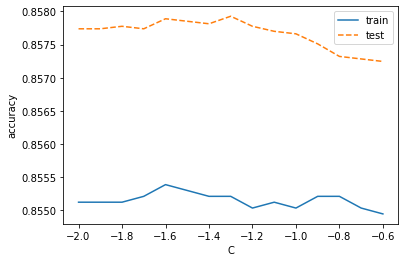

In [25]:
plt.plot(potentialaccu, accuplot[:, 0],
         label='train')
plt.plot(potentialaccu, accuplot[:, 1], linestyle='--',
         label='test')
plt.ylabel('accuracy')
plt.xlabel('C')
plt.legend(loc='upper right')
plt.xscale('linear')
#plt.savefig('images/03_08.png', dpi=300)
plt.show()

Therefore, C = -0.16

Since we both want to earn money and avoid the loss, we should consider the confusion matrix, namely true positive, false negative, false positive and false negative.

If it's a false negative, we miss a chance to earn money by predicting a quality client will not pay the loan; on the contrary, a false positive means we will lose huge money as we give loans to wrong people.

[[   38  3715]
 [   40 22588]]


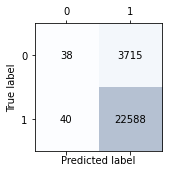

In [26]:
model1_LR = LogisticRegression(C=10**-1, random_state=0)
model1_LR.fit(X_train_trans, y_train)
model1_LR_pred = model1_LR.predict(X_test_trans)
train_pred = model1_LR.predict(X_train_trans)
confmat = confusion_matrix(y_true=y_test, y_pred=model1_LR_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [27]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=model1_LR_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=model1_LR_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=model1_LR_pred))
print('Fbeta0.8: %.3f' % fbeta_score(y_true=y_test, y_pred=model1_LR_pred, beta=0.8))

Precision: 0.859
Recall: 0.998
F1: 0.923
Fbeta0.8: 0.908


Lower precision means the model falsely grants loans to those who cannot afford it. F1 is the overall score if we consider losing potential quality clients is as important as borrowing money to the wrong people. Here beta=0.8 means the latter one is 0.8 times as important as the former one. We are now more risk-averse.

Then I will use the random forest model.

In [29]:
X_train.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,region_midwest,region_northeast,region_southeast,region_southwest,region_west
25545,3600.0,11.12,118.07,2,40000.0,7.53,0.0,1.0,3.0,0.0,...,0,0,0,1,0,0,0,1,0,0
23234,20000.0,6.54,371.08,3,65000.0,13.26,0.0,0.0,10.0,0.0,...,0,0,0,1,0,0,0,0,0,1
34115,13500.0,11.14,442.85,0,48526.8,17.48,0.0,3.0,8.0,0.0,...,0,0,0,1,0,0,1,0,0,0
784,13000.0,20.30,485.12,5,42000.0,7.69,0.0,1.0,5.0,0.0,...,0,0,0,1,0,1,0,0,0,0
37018,18000.0,11.89,596.96,9,72000.0,22.30,0.0,2.0,16.0,0.0,...,0,0,0,1,0,1,0,0,0,0


In [28]:
X_train_rf = X_train.copy()
X_train_rf['y'] = y_train
X_test_rf = X_test.copy()
X_test_rf['y'] = y_test
X_test_trans = tfdf.keras.pd_dataframe_to_tf_dataset(X_test_rf, label='y')
X_train_trans = tfdf.keras.pd_dataframe_to_tf_dataset(X_train_rf, label='y')
model_forest = tfdf.keras.RandomForestModel(verbose = 2)
model_forest.fit(X_train_trans)
#model_forest.summary()
model_forest.evaluate(X_test_trans)

Use 4 thread(s) for training
Use /var/folders/60/8ltyqqb94yx4pstnmdd7wl3w0000gn/T/tmp_topekvm as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'loan_amnt': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>, 'int_rate': <tf.Tensor 'data_11:0' shape=(None,) dtype=float64>, 'installment': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, 'emp_length': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'annual_inc': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'dti': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'delinq_2yrs': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'inq_last_6mths': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'open_acc': <tf.Tensor 'data_13:0' shape=(None,) dtype=float64>, 'pub_rec': <tf.Tensor 'data_14:0' shape=(None,) dtype=float64>, 'revol_bal': <tf.Tensor 'data_35:0' shape=(None,) dtype=float64>, 'revol_util': <tf.Tensor 'data_36:0' shape=(None,) dtype=float64>, 'total_acc': <tf.Tensor 

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


ValueError: in user code:

    File "/Users/zaiyingqi/opt/anaconda3/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py", line 1061, in _consumes_training_examples_until_eof  *
        num_examples += self.train_step(data)
    File "/Users/zaiyingqi/opt/anaconda3/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py", line 549, in _method_wrapper  *
        result = method(self, *args, **kwargs)
    File "/Users/zaiyingqi/opt/anaconda3/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py", line 550, in train_step  *
        return self.collect_data_step(data, is_training_example=True)
    File "/Users/zaiyingqi/opt/anaconda3/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py", line 549, in _method_wrapper  *
        result = method(self, *args, **kwargs)
    File "/Users/zaiyingqi/opt/anaconda3/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py", line 677, in collect_data_step  *
        normalized_semantic_inputs = tf_core.normalize_inputs(
    File "/Users/zaiyingqi/opt/anaconda3/lib/python3.8/site-packages/tensorflow_decision_forests/tensorflow/core_inference.py", line 221, in normalize_inputs  *
        raise ValueError(

    ValueError: Non supported tensor dtype <dtype: 'uint8'> for semantic Semantic.CATEGORICAL of feature home_ownership_MORTGAGE
